In [ ]:
url = 'https://raw.githubusercontent.com/SimonMcLain/TUS-Engineering-Team-Project/main/Data/HSE/COVID-19_HPSC_County_Statistics_Historic_Data.csv'

import pandas as pd

covid_19_dataset = pd.read_csv(url)

covid_19_dataset.head()

covid_19_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18590 entries, 0 to 18589
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   OBJECTID                        18590 non-null  int64  
 1   ORIGID                          18590 non-null  int64  
 2   CountyName                      18590 non-null  object 
 3   PopulationCensus16              18590 non-null  int64  
 4   TimeStamp                       18590 non-null  object 
 5   IGEasting                       18590 non-null  int64  
 6   IGNorthing                      18590 non-null  int64  
 7   Lat                             18590 non-null  float64
 8   Long                            18590 non-null  float64
 9   UGI                             18590 non-null  object 
 10  ConfirmedCovidCases             18590 non-null  int64  
 11  PopulationProportionCovidCases  18538 non-null  float64
 12  ConfirmedCovidDeaths            

In [ ]:
covid_19_dataset['TimeStamp'] = pd.to_datetime(covid_19_dataset['TimeStamp'], infer_datetime_format=True)

indexed_covid_19_dataset = covid_19_dataset.set_index(['TimeStamp'])

indexed_covid_19_dataset.head()

,OBJECTID,ORIGID,CountyName,PopulationCensus16,IGEasting,IGNorthing,Lat,Long,UGI,ConfirmedCovidCases,PopulationProportionCovidCases,ConfirmedCovidDeaths,ConfirmedCovidRecovered,Shape__Area,Shape__Length
TimeStamp,,,,,,,,,,,,,,,
2020-02-27,1,1,Carlow,56932,278661,163444,52.7168,-6.8367,http://data.geohive.ie/resource/county/2ae1962...,0,NaN,NaN,NaN,2.432352e+09,3.193486e+05
2020-02-27,2,2,Cavan,76176,246380,304501,53.9878,-7.2937,http://data.geohive.ie/resource/county/2ae1962...,0,NaN,NaN,NaN,5.575010e+09,5.159545e+05
2020-02-27,3,3,Clare,118817,133493,182732,52.8917,-8.9889,http://data.geohive.ie/resource/county/2ae1962...,0,NaN,NaN,NaN,8.722542e+09,1.013949e+06
2020-02-27,4,4,Cork,542868,156242,77860,51.9517,-8.6372,http://data.geohive.ie/resource/county/2ae1962...,0,NaN,NaN,NaN,1.952949e+10,2.129949e+06
2020-02-27,5,5,Donegal,159192,202615,405691,54.8989,-7.9600,http://data.geohive.ie/resource/county/2ae1962...,0,NaN,NaN,NaN,1.462404e+10,2.145086e+06


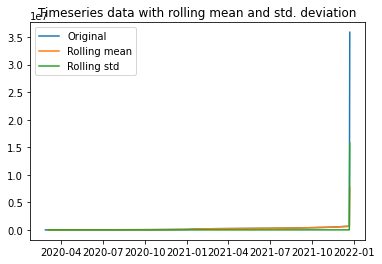

Test Statistics                0.554632
Mackinnons approx p-value      0.986442
used lags                     19.000000
NOBS                         643.000000
dtype: float64


In [ ]:
covid_19_confirmed_case_dataset = indexed_covid_19_dataset['ConfirmedCovidCases']

covid_19_confirmed_agg_dataset = covid_19_confirmed_case_dataset.groupby('TimeStamp').sum()

test_stationarity(covid_19_confirmed_agg_dataset)

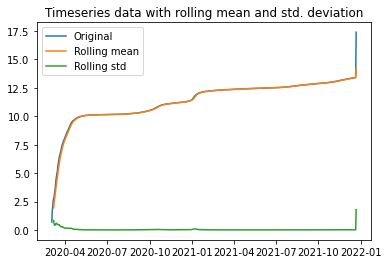

Test Statistics                0.135145
Mackinnons approx p-value      0.968380
used lags                      1.000000
NOBS                         658.000000
dtype: float64


In [ ]:
import numpy as np

covid_19_confirmed_agg_dataset_log_scaled = np.log(covid_19_confirmed_agg_dataset)
 
covid_19_confirmed_agg_dataset_log_scaled = covid_19_confirmed_agg_dataset_log_scaled[covid_19_confirmed_agg_dataset_log_scaled > 0]

test_stationarity(covid_19_confirmed_agg_dataset_log_scaled)

In [ ]:
def test_stationarity(timeseries):
  import matplotlib.pyplot as plt
  rolmean = timeseries.rolling(window=5).mean()
  rolstd = timeseries.rolling(window=5).std()

  orig = plt.plot(timeseries, label = 'Original')
  mean = plt.plot(rolmean, label='Rolling mean')
  std = plt.plot(rolstd, label='Rolling std')

  plt.legend(loc='best')
  plt.title('Timeseries data with rolling mean and std. deviation')
  plt.show()


  from statsmodels.tsa.stattools import adfuller

  dftest = adfuller(timeseries)
  dfoutput = pd.Series(dftest[0:4], index = ['Test Statistics', 'Mackinnons approx p-value', 'used lags','NOBS'])
  print(dfoutput)

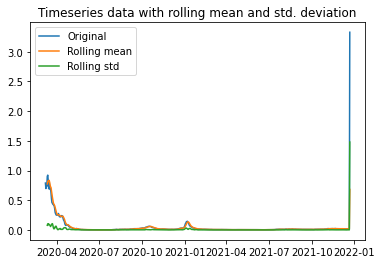

Test Statistics               -1.051451
Mackinnons approx p-value      0.734040
used lags                      0.000000
NOBS                         654.000000
dtype: float64


In [ ]:
ma = covid_19_confirmed_agg_dataset_log_scaled.rolling(window=6).mean()

covid_19_confirmed_agg_dataset_log_scaled_minus_ma = covid_19_confirmed_agg_dataset_log_scaled - ma

covid_19_confirmed_agg_dataset_log_scaled_minus_ma.dropna(inplace = True)

test_stationarity(covid_19_confirmed_agg_dataset_log_scaled_minus_ma)


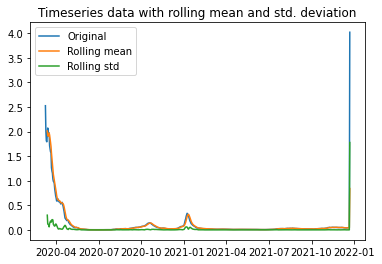

Test Statistics               -2.897491
Mackinnons approx p-value      0.045641
used lags                      0.000000
NOBS                         653.000000
dtype: float64


In [ ]:
covid_19_confirmed_agg_dataset_log_scaled_ps = covid_19_confirmed_agg_dataset_log_scaled.diff(periods=6)

covid_19_confirmed_agg_dataset_log_scaled_ps.dropna(inplace = True)

test_stationarity(covid_19_confirmed_agg_dataset_log_scaled_ps)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


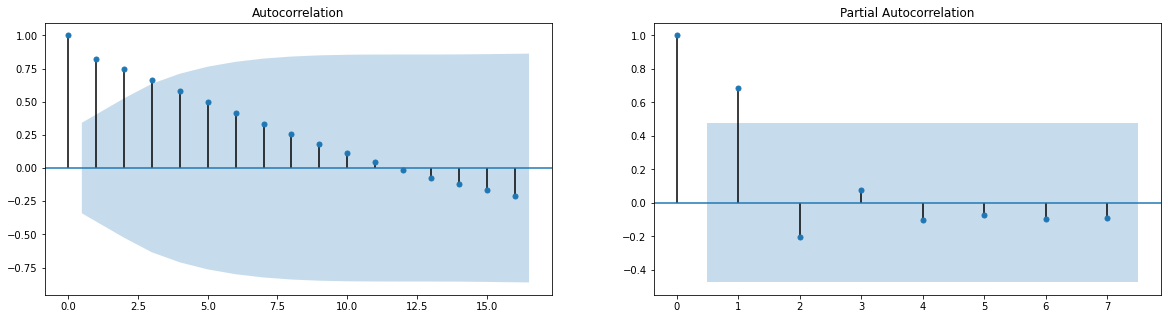

In [ ]:
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import matplotlib.pyplot as plt

lag_acf = acf(covid_19_confirmed_agg_dataset_log_scaled_ps, nlags = 32)
lag_pacf = pacf(covid_19_confirmed_agg_dataset_log_scaled_ps, nlags = 16)

fig,ax = plt.subplots(1,2,figsize=(20,5))

plot_acf(lag_acf, ax = ax[0])
plot_pacf(lag_pacf, lags = 7, ax = ax[1])

plt.show()

In [ ]:
def predict(timeseries,p,d,q):

  from statsmodels.tsa.arima_model import ARIMA

  from sklearn.model_selection import train_test_split

  timeseries.dropna(inplace = True)

  train, test = train_test_split(timeseries, test_size = 0.20, shuffle = False)

  model_arima = ARIMA(train, order=(p,d,q))

  model_arima_fit = model_arima.fit()

  predictions = model_arima_fit.predict(start='2021-08-14', end = '2021-12-22')

  from sklearn.metrics import mean_squared_error

  error = mean_squared_error(test, predictions)

  print('Test MSE %.5f' % error)

  predict = np.exp(predictions)
  test_set = np.exp(test)

  plt.plot(test_set)
  plt.plot(predict, color='red')
  plt.show()

  from pandas import DataFrame

  residual = DataFrame(model_arima_fit.resid)

  residual.plot(kind='kde')




In [ ]:
predict(covid_19_confirmed_agg_dataset_log_scaled_minus_ma, 10,2,3)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669

KeyError: ignored

In [ ]:
from sklearn.model_selection import train_test_split

covid_19_confirmed_agg_dataset_log_scaled_ps.dropna(inplace = True)

train, test= train_test_split(covid_19_confirmed_agg_dataset_log_scaled_ps,test_size = 0.20, shuffle = False)
test.head()


TimeStamp
2021-08-14    0.031784
2021-08-15    0.032687
2021-08-16    0.033055
2021-08-17    0.032535
2021-08-18    0.031874
Name: ConfirmedCovidCases, dtype: float64